In [1]:
import modern_robotics as mr
import numpy as np
from calibration import *
np.set_printoptions(precision = 16)

In [181]:
s = 0.001 # using mm as units

# A0 is prismatic joint - w0 is (0,0,0) and v0 is unit vector in the direction of translation
w0 = np.array([0,0,0])
q0 = np.array([0,0,0])*s
v0 = mr.ScrewToAxis(q0, w0, 0)
v0 = np.array([0, 0, 0, 1, 0, 0])

w1 = np.array([1,0,0])
q1 = np.array([0,0,0])*s
v1 = mr.ScrewToAxis(q1, w1, 0)

w2 = np.array([1,0,0])
q2 = np.array([0,0,1250])*s
v2 = mr.ScrewToAxis(q2, w2, 0)

w3 = np.array([0,1,0])
q3 = np.array([0,0,1250+45])*s
v3 = mr.ScrewToAxis(q3, w3, 0)

w4 = np.array([1,0,0])
q4 = np.array([0,740+360,1250+45])*s
v4 = mr.ScrewToAxis(q4, w4, 0)

w5 = np.array([0,1,0])
q5 = np.array([0,0,1250+45])*s
v5 = mr.ScrewToAxis(q5, w5, 0)

xi0 = np.c_[v1, v2, v3, v4, v5]

In [182]:
wist0 = np.array([0,0,0])
vist0 = np.array([0,1310,1295])*s

xist0 = np.r_[wist0, vist0]


# introducing some random error

w01=np.array([0.9989, -0.0089, 0.0009])
q01=np.array([0.0010, 0.0200, 0])*s
v01 = mr.ScrewToAxis(q01, w01, 0)

w02=np.array([0.9989, 0.0034, 0.0005]) 
q02 = np.array([-0.0200, 0.0500, 1254.8])*s
v02 = mr.ScrewToAxis(q02, w02, 0)

w03=np.array([0.0078, 0.9940, -0.0010])
q03=np.array([0.0374, 0.0074, 1250+44.8])*s
v03 = mr.ScrewToAxis(q03, w03, 0)

w04=np.array([0.9999, 0.0109, -0.0119])
q04 = np.array([0.0251, 740+(0.01)+360+(0.002), 1250+45+(-0.002)])*s
v04 = mr.ScrewToAxis(q04, w04, 0)

w05=np.array([0.0009, 0.9999, 0])
q05=np.array([0.0013, -0.0105, 1250+45+(-0.03)])*s
v05 = mr.ScrewToAxis(q05, w05, 0)

xi00 = np.c_[v01, v02, v03, v04, v05]

#initial twist
xist00=np.array([0.002, -0.001, 0.001, 0.0085, 1310, 1295])
xist00[3:6] = xist00[3:6]*s


mean_error_before = np.zeros((10,1))
mean_error_traditional = np.zeros((10,1))
nmean_error_traditional = np.zeros((10,1))

max_error_before = np.zeros((10,1))
max_error_traditional = np.zeros((10,1))
nmax_error_traditional = np.zeros((10,1))

# fixing random seed for reproducibility
np.random.seed(19680801)


In [185]:
xi00 = xiTFP
xist00 = xistTFP

In [186]:
# for N in np.arange(10,110,10):
for N in [10]:

    P01=np.array([100, 0, 0]) * s
    
    P02=np.array([0, 100, 0]) * s
    
    P03=np.array([0, 0, 100]) * s
    
    PX=np.c_[P01, P02, P03]

    P04=np.array([-100, -100, -100]) * s
    
    gm=np.zeros((4, 4, N))
    
    gn=np.zeros((4, 4, N))
    
    Pa1=np.zeros((4, N))
    
    Pa2=np.zeros((4, N))
    
    Pa3=np.zeros((4, N))
    
    cali_joint_angles = np.random.rand(N, 5) * 2 * np.pi - np.pi

    for i in range(0,N):
        
        Pa1[:, i] = np.dot(mr.FKinSpace(se3_exp(xist00), xi00, cali_joint_angles[i, :]), np.r_[P01, 1].reshape((4, 1)) ).reshape((4,)) #+ ((np.random.rand(4, 1) * 0.2 - 0.1) * s).reshape((4,))
        
        Pa2[:, i] = np.dot(mr.FKinSpace(se3_exp(xist00), xi00, cali_joint_angles[i, :]), np.r_[P02, 1].reshape((4, 1)) ).reshape((4,)) #+ ((np.random.rand(4, 1) * 0.2 - 0.1) * s).reshape((4,))
        
        Pa3[:, i] = np.dot(mr.FKinSpace(se3_exp(xist00), xi00, cali_joint_angles[i, :]), np.r_[P03, 1].reshape((4, 1)) ).reshape((4,)) #+ ((np.random.rand(4, 1) * 0.2 - 0.1) * s).reshape((4,))
        
        PY = np.c_[Pa1[0:3, i], Pa2[0:3, i], Pa3[0:3, i]]

        R, t = registration(PX, PY)

        gm[0:3, 0:3, i] = R
        
        gm[0:3, 3, i] = t
        
        gn[:, :, i] = mr.FKinSpace(se3_exp(xist00), xi00, cali_joint_angles[i, :])

    
    xiTFP, xistTFP = traditional_calibration_5dof(xi0, xist00, cali_joint_angles, np.round(gm, 4), 10)

    nxiTFP, nxistTFP = traditional_calibration_ndof(xi0, xist00, cali_joint_angles, np.round(gm, 4), 10)

    Nt=40

    error_before=np.zeros((Nt,1))

    error_afterTraditional=np.zeros((Nt,1))

    nerror_afterTraditional=np.zeros((Nt,1))

    test_joint_config = np.random.rand(Nt,5) * 2 * np.pi - np.pi

    for i in range(0, Nt):
        
        error_before[i] = np.linalg.norm( np.dot( mr.FKinSpace(se3_exp(xist0), xi0, test_joint_config[i,:]) - mr.FKinSpace(se3_exp(xist00), xi00, test_joint_config[i,:]), np.r_[P04,1])) / s
        
        error_afterTraditional[i] = np.linalg.norm( np.dot( mr.FKinSpace(se3_exp(xistTFP), xiTFP, test_joint_config[i,:]) - mr.FKinSpace(se3_exp(xist00), xi00, test_joint_config[i,:]), np.r_[P04,1]))  / s

        nerror_afterTraditional[i] = np.linalg.norm( np.dot( mr.FKinSpace(se3_exp(nxistTFP), nxiTFP, test_joint_config[i,:]) - mr.FKinSpace(se3_exp(xist00), xi00, test_joint_config[i,:]), np.r_[P04,1]))  / s

    idx = int(N/10) - 1

    mean_error_before[idx, 0] = np.mean(error_before)

    mean_error_traditional[idx, 0] = np.mean(error_afterTraditional)

    nmean_error_traditional[idx, 0] = np.mean(error_afterTraditional)



In [187]:
print("Mean error before: ", mean_error_before[0])
print("Mean error traditional: ", mean_error_traditional[0])
print("Mean error ntraditional: ", nmean_error_traditional[0])

Mean error before:  [21.752898394840923]
Mean error traditional:  [0.2275001354289104]
Mean error ntraditional:  [0.2275001354289104]


In [5]:
import matplotlib.pyplot as plt 

In [332]:
def plot_workcell(a):
    ax = plt.figure().add_subplot(projection="3d")

    fig = plt.figure(figsize=(20,12))
    ax = fig.add_subplot(projection='3d')

    workcell_width = 2.5
    workcell_depth = 2.5
    workcell_height = 2.5

    work_cell_x = np.array([0, workcell_width, workcell_width, 0, 0, 0, workcell_width, workcell_width, 0, 0]) 
    work_cell_y = np.array([0, 0, workcell_depth, workcell_depth, 0, 0, 0, workcell_depth, workcell_depth, 0 ])
    work_cell_z = np.array([0, 0, 0, 0, 0, workcell_height, workcell_height, workcell_height, workcell_height, workcell_height ])

    redcam_x = 1.0
    redcam_y = 1.25
    redcam_z = 1.00


    a0 = a[0]
    a1 = a[1]
    a2 = 90.0 + a[2]
    a3 = a[3]

    # plot the prismatic axis  
    x0s = 0.25
    x0e = 2.25

    y0s = 0.25 
    y0e = 0.25

    z0s = 0.25 
    z0e = 0.25

    a0_x = np.array([x0s, x0e])
    a0_y = np.array([y0s,  y0e])
    a0_z = np.array([z0s, z0e])



    # plot robot 
    x1 =  a0
    y1 = 0.25
    z1 = z0e + 0.2

    x1s = x1 
    x1e = x1 
    y1s = y0s
    y1e = y1
    z1s = z0s
    z1e = z1 

    a1_x = np.array([x1s, x1e])
    a1_y = np.array([y1s, y1e])
    a1_z = np.array([z1s, z1e])


    x2 = x1s
    y2 = y1s + 0.35  
    z2 = z1 

    x2s = x1e 
    x2e = x2 
    y2s = y1e
    y2e = y2
    z2s = z1e
    z2e = z2 + 0.4 

    a2_x = np.array([x2s, x2e, x2e])
    a2_y = np.array([y2s, y2e, y2e])
    a2_z = np.array([z2s, z2e - 0.4, z2e])


    x3 = x2e
    y3 = y2e + 1.25 * np.sin(a1*(np.pi/180))
    z3 = z2 +  1.25 * np.cos(a1*(np.pi/180))

    x3s = x2e 
    x3e = x3 
    y3s = y2e 
    y3e = y3 
    z3s = z2e
    z3e = z3 

    a3_x = np.array([x3s, x3e])
    a3_y = np.array([y3s, y3e])
    a3_z = np.array([z3s, z3e])

    x4 = x3e
    y4 = y3e +  1.1  * np.sin(a2*(np.pi/180))
    z4 = z3  +  1.1  * np.cos(a2*(np.pi/180))

    x4s = x3e 
    x4e = x4 
    y4s = y3e
    y4e = y4
    z4s = z3e
    z4e = z4 

    a4_x = np.array([x4s, x4s, x4e])
    a4_y = np.array([y4s, y4s + 0.045*np.sin(a3*(np.pi/180)), y4e])
    a4_z = np.array([z4s, z4s + 0.045*np.cos(a3*(np.pi/180)), z4e])

    x5 = x4e
    y5 = y4e + 0.21 * np.sin(a2*(np.pi/180))
    z5 = z4  + 0.21 * np.cos(a2*(np.pi/180))

    x5s = x4e 
    x5e = x5 
    y5s = y4e
    y5e = y5
    z5s = z4e
    z5e = z5 

    a5_x = np.array([x5s, x5e])
    a5_y = np.array([y5s, y5e])
    a5_z = np.array([z5s, z5e])

    x6 = x5e
    y6 = y5e
    z6 = z5 - 0.3 - a3

    x6s = x5e 
    x6e = x6 
    y6s = y5e
    y6e = y6
    z6s = z5e
    z6e = z6 

    a6_x = np.array([x6s, x6e])
    a6_y = np.array([y6s, y6e])
    a6_z = np.array([z6s, z6e])


    # initiate the workcell 
    ax.plot(work_cell_x, work_cell_y, work_cell_z, linewidth=0.2, color='k')

    ax.plot(a0_x, a0_y, a0_z, linewidth=2, color='b')
    ax.plot(a1_x, a1_y, a1_z, linewidth=2, color='k')
    ax.plot(a2_x, a2_y, a2_z, linewidth=2, color='r')
    ax.plot(a3_x, a3_y, a3_z, linewidth=2, color='y')
    ax.plot(a4_x, a4_y, a4_z, linewidth=2, color='g')
    ax.plot(a5_x, a5_y, a5_z, linewidth=2, color='k')
    ax.plot(a6_x, a6_y, a6_z, linewidth=2, color='g')

    ax.scatter(redcam_x + pt1[:,0],    redcam_y + pt1[:,1],    redcam_z + pt1[:,2], c='g')
    ax.scatter(redcam_x + pt2[:,0],    redcam_y + pt2[:,1],    redcam_z + pt2[:,2], c='b')
    ax.scatter(redcam_x + pt3[:,0],    redcam_y + pt3[:,1],    redcam_z + pt3[:,2], c='r')
    ax.scatter(redcam_x + centre[:,0], redcam_y + centre[:,1], redcam_z + centre[:,2], c='k')



    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")
    ax.set_zlabel("Z [m]")
    ax.set_title("Workcell") 
    plt.show()

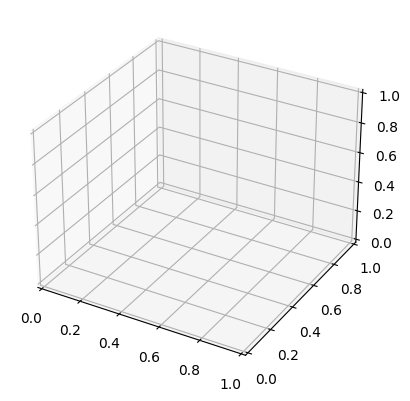

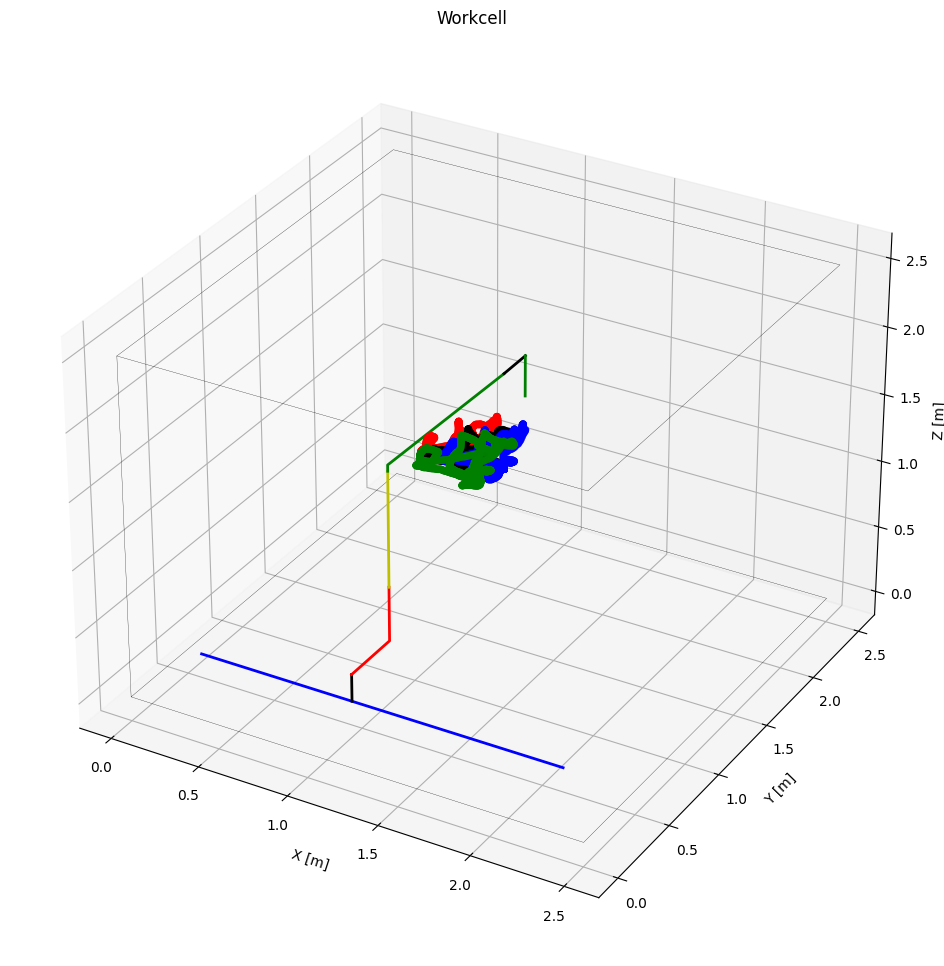

In [333]:
plot_workcell(np.array([1.1, 0, 0, 0]))

In [2]:
trajectory = np.loadtxt("trajectory.csv", delimiter=',')

In [3]:
pt1 = trajectory[:,0:3]
pt2 = trajectory[:,3:6]
pt3 = trajectory[:,6:9]
centre = (pt1 + pt2 + pt3)/3

In [74]:
redcam_x = 1.0
redcam_y = 1.25 - 0.25
redcam_z = 1.00 - 0.25

pt1_rc = trajectory[:,0:3]
pt2_rc = trajectory[:,3:6]
pt3_rc = trajectory[:,6:9]
centre_rc = (pt1_rc + pt2_rc + pt3_rc)/3

In [75]:
# pt1_rb = redcam_x + pt1_rc[:,:]
# pt2_rb = redcam_y + pt2_rc[:,:]
# pt3_rb = redcam_z + pt3_rc[:,:]
pt1_rb = redcam_x + centre_rc[:,:] + pt1_rc[:,:]
pt2_rb = redcam_y + centre_rc[:,:] + pt2_rc[:,:]
pt3_rb = redcam_z + centre_rc[:,:] + pt3_rc[:,:]


In [90]:
ptsx1 = []
ptsx2 = []
ptsx3 = []

ptsy1 = []
ptsy2 = []
ptsy3 = []

for idx in range(0, np.size(pt1_rb,0),1):

    if idx % 5 == 0:

        py1=np.array([pt1_rb[idx, 0], pt1_rb[idx, 1], pt1_rb[idx, 2]]) 
        py2=np.array([pt2_rb[idx, 0], pt2_rb[idx, 1], pt2_rb[idx, 2]]) 
        py3=np.array([pt3_rb[idx, 0], pt3_rb[idx, 1], pt3_rb[idx, 2]]) 

        px1=np.array([pt1_rc[idx, 0], pt1_rc[idx, 1], pt1_rc[idx, 2]]) 
        px2=np.array([pt2_rc[idx, 0], pt2_rc[idx, 1], pt2_rc[idx, 2]]) 
        px3=np.array([pt3_rc[idx, 0], pt3_rc[idx, 1], pt3_rc[idx, 2]]) 

        
        ptsy1.append(py1)
        ptsy2.append(py2)
        ptsy3.append(py3)
        
        ptsx1.append(px1)
        ptsx2.append(px2)
        ptsx3.append(px3)

In [92]:
pptsx = np.array(ptsx1 + ptsx2 + ptsx3)
pptsy = np.array(ptsy1 + ptsy2 + ptsy3)

In [93]:
R, t = registration(np.array(pptsx).T, np.array(pptsy).T)

In [94]:
R

array([[ 0.9687118710183615, -0.1550226665529099, -0.1938176560660286],
       [ 0.1678712270071898,  0.9844562566334328,  0.0516248963038927],
       [ 0.1828019750746821, -0.0825460576291348,  0.9796783075472688]])

In [95]:
t

array([0.9510755698836735, 1.3655571196489733, 1.0083019857446196])

In [98]:
np.dot(mr.RpToTrans(R,t), np.r_[px1,1])

array([0.90797020122772  , 1.7404883906596742, 0.9119352890570316,
       1.                ])

In [99]:
py1

array([0.9938460780863093, 1.8477926085187812, 0.8661677955178655])

In [10]:
import scipy.spatial


In [20]:
point_cloud_1 = pptsx
point_cloud_2 = pptsy
threshold = 1
error = np.inf
while error > threshold:
    # Find the nearest neighbors between the two point clouds
    tree = scipy.spatial.KDTree(point_cloud_1)
    distances, indices = tree.query(point_cloud_2)

    # Compute the centroids of the two point clouds
    centroid_1 = np.mean(point_cloud_1, axis=0)
    centroid_2 = np.mean(point_cloud_2, axis=0)

    # Subtract the centroids from the point clouds
    centered_point_cloud_1 = point_cloud_1 - centroid_1
    centered_point_cloud_2 = point_cloud_2 - centroid_2

    # Compute the covariance matrix
    covariance_matrix = np.dot(centered_point_cloud_2.T, centered_point_cloud_1)

    # Compute the singular value decomposition of the covariance matrix
    U, S, V = np.linalg.svd(covariance_matrix)

    idx = np.argsort(covariance_matrix)[::-1]
    S = S[idx]
    U = U[:, idx]
    V = V[idx, :].T

    # Compute the rotation matrix
    # rotation_matrix = np.dot(V.T, U.T)
    rotation_matrix = np.dot(np.dot(V, np.diag([1, 1, np.linalg.det(np.dot(V, U.T))])), U.T)

    # Compute the translation vector
    # translation_vector = centroid_1 - np.dot(rotation_matrix, centroid_2)
    translation_vector = centroid_2 - np.dot(R, centroid_1)

    # Update the point clouds and the error
    point_cloud_2 = np.dot(point_cloud_2, rotation_matrix) + translation_vector
    error = np.linalg.norm(point_cloud_1 - point_cloud_2)
    print(error)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [18]:
pptsy.shape

(2349, 3)

In [467]:
mr.RpToTrans(R,t)

array([[ 0.9759777705281171, -0.0484964725967118, -0.212404057354474 ,
         1.1134668450462624],
       [ 0.0266591516985425,  0.9941681613125591, -0.1044938116020241,
         1.0918509197644186],
       [ 0.2162329324263084,  0.0963211252949298,  0.9715789004276687,
         1.0513955154041263],
       [ 0.                ,  0.                ,  0.                ,
         1.                ]])